# Bert Practice
We're going to use BERT embeddings as features to train a text classification model. The dataset contains movie reviews from imdb, and the label is whether the review is positive or negative.

-  We will first use the embedding model to create embeddings for the `text` column, and turn the array produced back into a DataFrame. We will check how many dimensions the embeddings have.
- Next, we will train the classifier. We will check the text of the examples in the test set that the classifier gets wrong.


In [1]:
import urllib.request
import tarfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# We're loading text data that is stored in a tar file into

n_examples = 200

url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
urllib.request.urlretrieve(url, filename='aclImdb_v1.tar.gz')


texts = []
with tarfile.open('./aclImdb_v1.tar.gz', 'r:gz') as tf:
    m = tf.getmembers()
    neg_paths = [i for i in m if i.path.startswith('aclImdb/train/neg') and i.path.endswith('.txt')]
    pos_paths = [i for i in m if i.path.startswith('aclImdb/train/pos') and i.path.endswith('.txt')]

    for i in neg_paths[:n_examples]:
        texts.append({
            'label': 'neg',
            'text': tf.extractfile(i).read().decode('utf8'),
        })
    for i in pos_paths[:n_examples]:
        texts.append({
            'label': 'pos',
            'text': tf.extractfile(i).read().decode('utf8'),
        })

texts_df = pd.DataFrame(texts)

In [3]:
texts_df

,label,text
0,neg,I rented I AM CURIOUS-YELLOW from my video sto...
1,neg,"""I Am Curious: Yellow"" is a risible and preten..."
2,neg,If only to avoid making this type of film in t...
3,neg,This film was probably inspired by Godard's Ma...
4,neg,"Oh, brother...after hearing about this ridicul..."
...,...,...
395,pos,"I'm a huge classic film buff, but am just gett..."
396,pos,Marion Davies stars in this remarkable comedy ...
397,pos,There are some wonderful things about this mov...
398,pos,I finally purchased and added to my collection...


In [4]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
# Use 'embedding_model' to create an embedding for each text
embeddings = embedding_model.encode(texts_df['text'])
# Convert 'embeddings' into a dataframe
embeddings_df = pd.DataFrame(embeddings)
embeddings_df = embeddings_df.rename(columns=lambda x: 'embedding_dim_' + str(x))
X = pd.concat([texts_df, embeddings_df], axis=1)
y = texts_df['label']

In [10]:
# How many dimensions are in the embedding?

number_of_dimensions_in_the_embedding = embeddings.shape[1]
number_of_dimensions_in_the_embedding

384

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=211)
model = HistGradientBoostingClassifier()
embedding_feature_names = [i for i in X.columns if i.startswith('embedding_dim_')]
model.fit(X_train[embedding_feature_names], y_train)

y_train_pred = model.predict(X_train[embedding_feature_names])
y_test_pred = model.predict(X_test[embedding_feature_names])

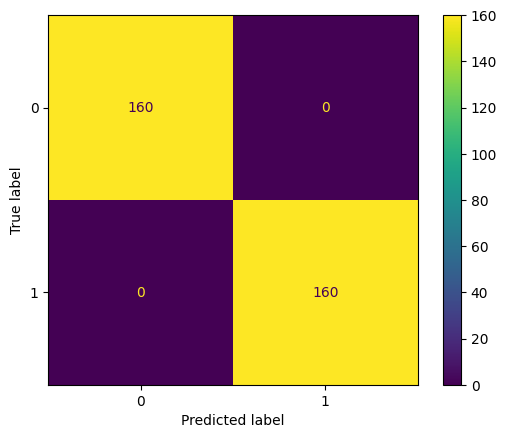

In [13]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred)).plot()

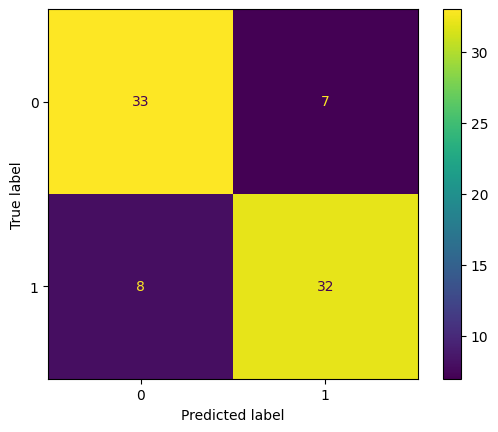

In [14]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()

In [15]:
X_test[y_test != y_test_pred][['text', 'label']]

,text,label
180,"Well, as Goethe once said, there really isn't ...",neg
329,I'm sure that not many people outside of Austr...,pos
236,Generally it was a good movie with an ideal en...,pos
338,The only reason I wanted to see this was becau...,pos
46,Lifetime did it again. Can we say stupid? I co...,neg
344,I watched this on the movies with my girlfrien...,pos
189,"This film, The Alamo:Thirteen Days to Glory, i...",neg
50,"I saw this film opening weekend in Australia, ...",neg
337,How could I possibly pass up the chance to see...,pos
66,"There's not a drop of sunshine in ""The Sunshin...",neg


# Music Genres from Wikidata
- Using UMAP, we will produce a 2-dimensional scatterplot which shows the embeddings of these words.
- Using cosine similarity, we will also deterime which genre is most similar to Argentine tango

In [16]:
%pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import pandas as pd

In [19]:
genres_df = pd.read_html("https://www.wikidata.org/wiki/Wikidata:WikiProject_Music/Lists/Instance_of_music_genre")[0]
genres = genres_df['label'].tolist()
genre_embeddings = pd.DataFrame(embedding_model.encode(genres_df['label'].tolist()))
genre_embeddings = genre_embeddings.assign(text = genres_df['label'].tolist(), )

# Just take the first 50 genres for speed/readability
genre_embeddings = genre_embeddings.head(50)

In [20]:
genre_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,text
0,-0.050982,0.036314,-0.018681,0.064923,-0.155699,-0.007342,0.066791,-0.031713,0.002916,-0.092707,...,-0.003042,0.041154,0.098299,-0.036554,0.046602,0.097419,0.023119,0.007499,-0.019451,opera
1,0.002608,-0.017491,0.010264,-0.013854,-0.126910,0.109770,0.073662,-0.037481,0.034074,0.001816,...,-0.008417,-0.072247,0.160962,-0.087497,0.009758,0.076527,0.039773,0.106755,0.028148,musical
2,-0.039175,-0.025080,-0.029659,-0.011583,-0.018167,0.051054,0.127290,-0.029419,0.012948,0.041054,...,-0.001654,-0.075696,0.121836,-0.089039,0.038978,0.056823,-0.083264,0.114786,-0.055849,punk rock
3,0.018308,0.057893,-0.036484,-0.044937,-0.096685,0.101979,0.059316,-0.104192,0.028501,0.049499,...,0.031733,-0.121287,0.033099,-0.044816,0.082672,0.079995,-0.034931,0.058770,-0.061914,music of Israel
4,-0.021784,0.016750,-0.048389,-0.007419,-0.071243,-0.036559,0.175235,0.006926,0.009023,0.042399,...,-0.001618,0.053566,0.088876,-0.052120,-0.047264,0.042486,0.091393,0.078582,-0.010223,conjunto


In [23]:
# Initialize the umap reducer object
reducer = umap.UMAP(n_components=2)
embedding_columns = [c for c in genre_embeddings.columns if c not in ('text', )]
# Fit the reducer
reducer.fit(genre_embeddings[embedding_columns])
# Transform the embeddings (make sure to select only the embedding columns, not the text one)
embeddings_2dim_df = pd.DataFrame(reducer.transform(genre_embeddings[embedding_columns]))
embeddings_2dim_df['text'] = genre_embeddings['text']
embeddings_2dim_df.head()

,0,1,text
0,17.033850,5.862311,opera
1,16.957926,3.717378,musical
2,14.603019,3.211158,punk rock
3,16.993769,4.141925,music of Israel
4,15.694930,6.101619,conjunto


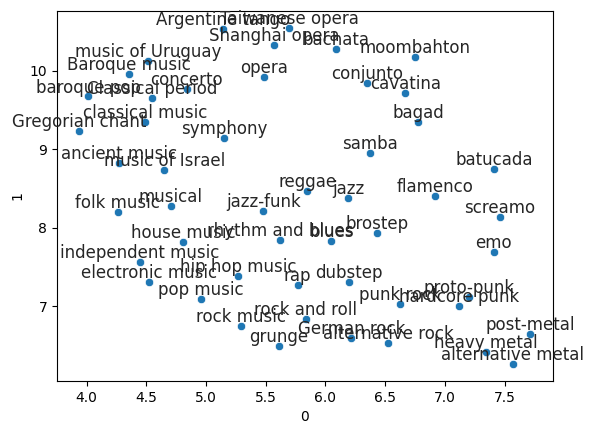

In [22]:
ax = sns.scatterplot(embeddings_2dim_df, x=0, y=1)

sns.set_theme(rc={'figure.figsize':(16, 16)})

for i, row in embeddings_2dim_df.iterrows():
    ax.text(row[0], row[1], row['text'], ha='center', va='bottom')

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(genre_embeddings[embedding_columns])
similarity_matrix

array([[1.0000004 , 0.5216421 , 0.2295627 , ..., 0.2637312 , 0.28494588,
        0.43558407],
       [0.5216421 , 0.9999999 , 0.46951655, ..., 0.6127705 , 0.526256  ,
        0.5300308 ],
       [0.2295627 , 0.46951655, 1.0000002 , ..., 0.45182872, 0.39687645,
        0.33746046],
       ...,
       [0.2637312 , 0.6127705 , 0.45182872, ..., 0.9999999 , 0.55173093,
        0.4587261 ],
       [0.28494588, 0.526256  , 0.39687645, ..., 0.55173093, 1.0000005 ,
        0.38559496],
       [0.43558407, 0.5300308 , 0.33746046, ..., 0.4587261 , 0.38559496,
        0.99999994]], dtype=float32)

In [25]:
from sklearn.metrics.pairwise import cosine_similarity


similarity_matrix = cosine_similarity(genre_embeddings[embedding_columns])
similarity_matrix = pd.DataFrame(
    similarity_matrix,
    index = genre_embeddings['text'],
    columns = genre_embeddings['text'],
)
similarity_matrix.head()

text,opera,musical,punk rock,music of Israel,conjunto,rap,rock and roll,jazz,Baroque music,classical music,...,pop music,jazz-funk,heavy metal,bachata,cavatina,post-metal,independent music,folk music,rhythm and blues,baroque pop
text,,,,,,,,,,,,,,,,,,,,,
opera,1.000000,0.521642,0.229563,0.307693,0.263503,0.270796,0.269890,0.261310,0.431164,0.502843,...,0.357149,0.181396,0.293607,0.383006,0.240294,0.255979,0.308161,0.263731,0.284946,0.435584
musical,0.521642,1.000000,0.469517,0.606184,0.272070,0.540032,0.567829,0.512186,0.569208,0.695227,...,0.616566,0.435339,0.412726,0.376752,0.264201,0.305562,0.612066,0.612770,0.526256,0.530031
punk rock,0.229563,0.469517,1.000000,0.351759,0.129041,0.566000,0.690186,0.412037,0.269167,0.341567,...,0.533609,0.425436,0.410855,0.073621,0.151122,0.373449,0.387770,0.451829,0.396876,0.337460
music of Israel,0.307693,0.606184,0.351759,1.000000,0.106074,0.426947,0.434916,0.445759,0.508359,0.603779,...,0.506862,0.417046,0.266140,0.375819,0.235252,0.198357,0.536994,0.498965,0.438918,0.411733
conjunto,0.263503,0.272070,0.129041,0.106074,1.000000,0.128563,0.116704,0.236331,0.229021,0.211430,...,0.068114,0.170330,0.085575,0.292054,0.396593,0.128965,0.120958,0.189375,0.175141,0.157792


<Axes: xlabel='text', ylabel='text'>

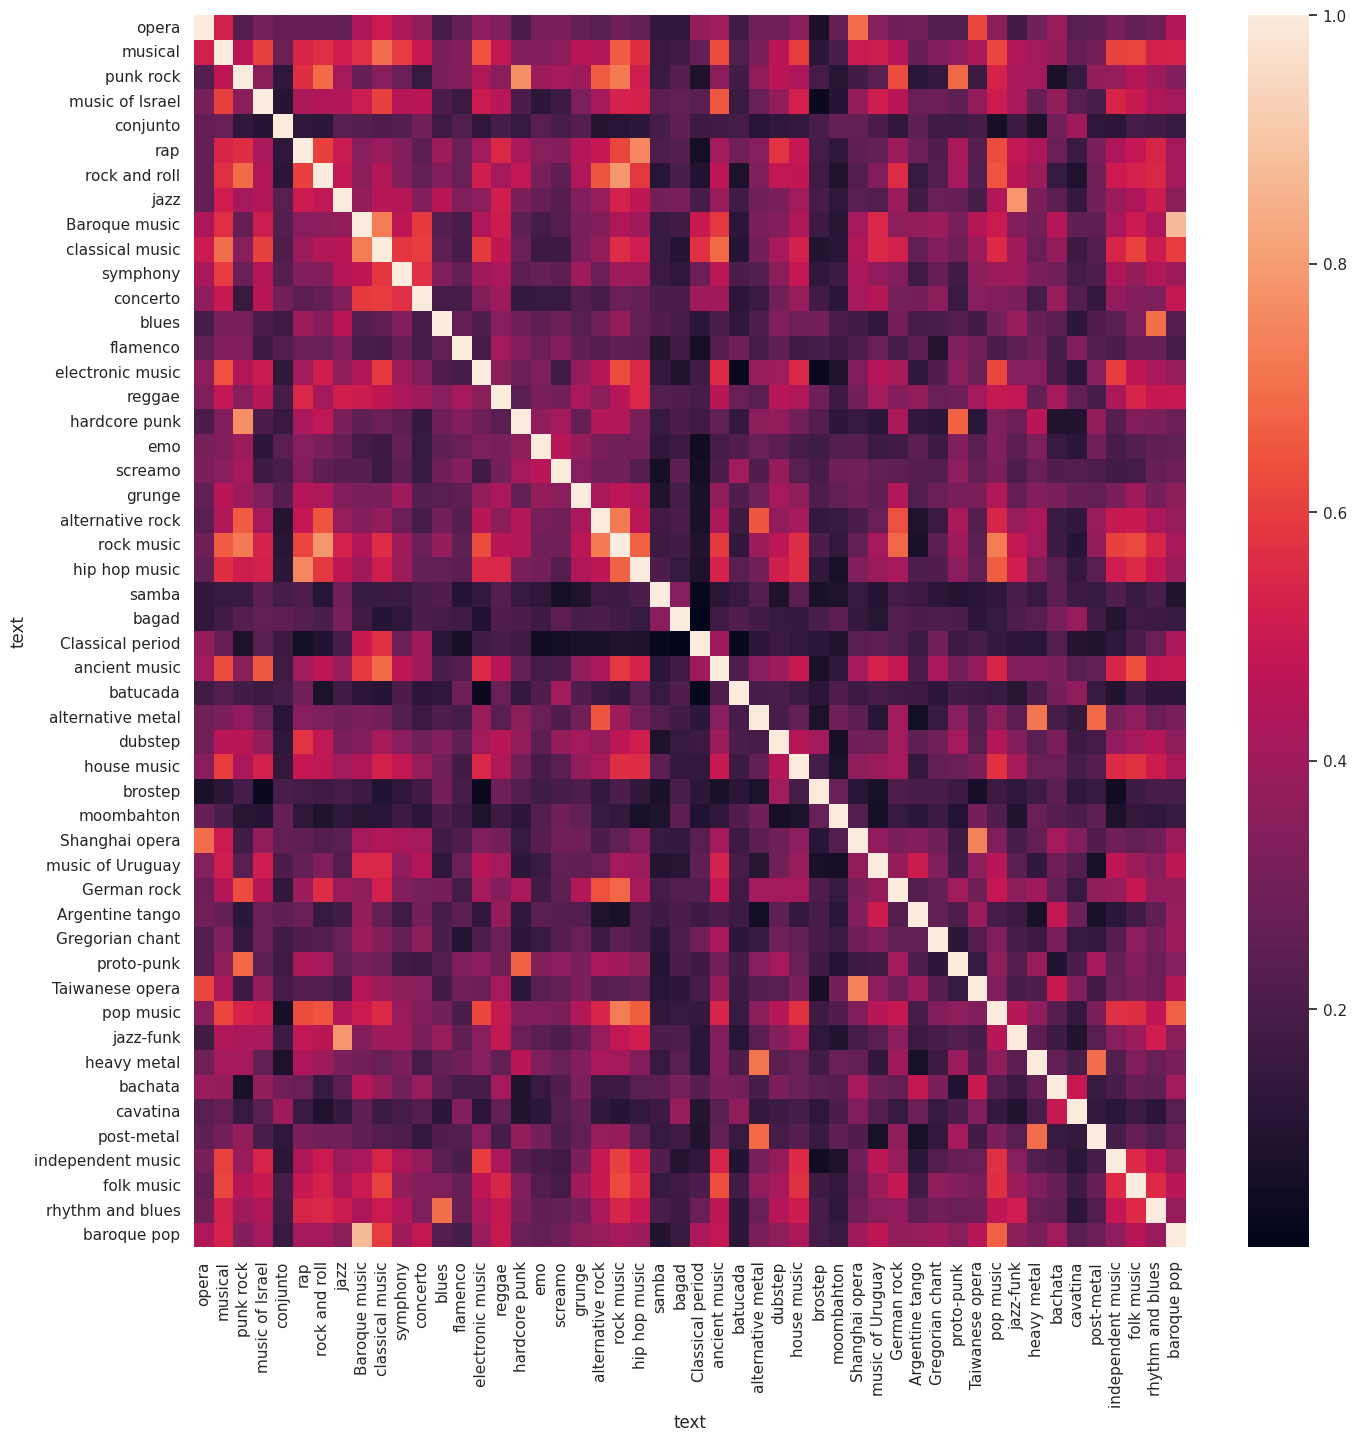

In [26]:
sns.heatmap(similarity_matrix)

In [27]:
most_similar_2_genres_to_argentine_tango = ["Music of Uruguay", "bachata"]

In [28]:
most_similar_2_genres_to_argentine_tango = similarity_matrix['Argentine tango'].sort_values(ascending=False).head(3)
most_similar_2_genres_to_argentine_tango

,Argentine tango
text,
Argentine tango,1.000000
music of Uruguay,0.505699
bachata,0.483124


# Vector Arithmetic
We're going to use vector arithmetic to find the capitals of U.S States.

- We will calculate the differences between the embedding of each capital and the embedding of the corresponding state name
- We will also calculate the State->Capital direction by taking the average of these differences
- We will then add the average distance back to each state
- Lastly, we will calculate the similarity matrix and find the most similar capital to the prediction for each state

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
capitals_df = pd.read_html("https://simple.wikipedia.org/wiki/List_of_U.S._state_capitals")[0]
capitals_df.columns = [c[1] for c in capitals_df.columns] # Remove MultiIndex
capitals_df.head()

,State,Abr.,State-hood,Capital,Capital since,Area (mi²),City,Metropolitan,Rank in state,Rank in US,Notes
0,Alabama,AL,1819,Montgomery,1846,159.8,198218,373903.0,2,119.0,NaN
1,Alaska,AK,1959,Juneau,1906,2716.7,31275,NaN,2,NaN,Largest capital by municipal land area.
2,Arizona,AZ,1912,Phoenix,1889,517.6,1660272,4857962.0,1,5.0,Largest capital by population.
3,Arkansas,AR,1836,Little Rock,1821,116.2,193524,699757.0,1,117.0,NaN
4,California,CA,1850,Sacramento,1854,97.9,508529,2345210.0,6,35.0,NaN


In [32]:
state_embeddings = pd.DataFrame(embedding_model.encode(capitals_df['State'].tolist()))
state_embeddings = state_embeddings.assign(text = capitals_df['State'], type='state')
capital_embeddings = pd.DataFrame(embedding_model.encode(capitals_df['Capital'].tolist()))
capital_embeddings = capital_embeddings.assign(text = capitals_df['Capital'], type='capital')

all_embeddings = pd.concat((capital_embeddings, state_embeddings)).reset_index(drop=True)
all_embeddings

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,text,type
0,-0.058425,0.028055,-0.034530,0.103942,-0.027704,0.002798,0.018394,0.013123,-0.048226,-0.025855,...,0.031730,-0.022455,-0.068965,0.065852,0.082528,0.001139,-0.005290,0.021728,Montgomery,capital
1,0.017618,0.020219,-0.010096,0.063336,-0.031864,0.009057,-0.047663,-0.033440,-0.013342,0.016305,...,-0.064507,0.027988,0.060130,0.009883,0.018484,0.019514,-0.028550,0.006057,Juneau,capital
2,0.076791,0.035226,-0.065225,0.086447,-0.081289,-0.027309,0.065636,-0.125013,-0.025297,-0.018818,...,0.096178,-0.073298,-0.020221,0.079798,0.090875,0.021926,0.013725,0.013303,Phoenix,capital
3,0.039473,0.069554,0.000198,0.004148,0.030751,0.026697,0.064375,-0.012615,0.002217,0.039143,...,0.044215,0.085366,-0.073830,0.007677,0.003131,0.037998,0.075006,-0.024903,Little Rock,capital
4,0.085825,0.048734,-0.010073,0.039293,-0.072720,-0.038207,0.028069,-0.010112,-0.001784,0.025099,...,-0.056416,0.022414,0.001754,0.080625,0.132871,0.068254,0.024879,-0.067318,Sacramento,capital
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.046313,0.059218,0.027663,0.032996,-0.026470,-0.000224,-0.030995,-0.069229,-0.014405,0.026441,...,0.022041,0.015209,0.011511,0.028857,0.082268,0.008451,-0.045909,-0.054937,Virginia,state
96,0.029875,0.072954,0.041962,0.061929,-0.030590,0.010886,0.024274,-0.042139,-0.004609,0.044777,...,-0.033077,-0.065171,-0.040877,0.061750,0.086398,0.047509,-0.025110,0.030014,Washington,state
97,0.033667,0.054539,0.000541,0.017279,-0.007229,-0.023036,-0.012462,-0.057511,-0.012983,0.051543,...,0.029631,-0.014673,0.002720,0.013424,0.060022,-0.003530,-0.049037,-0.064786,West Virginia,state
98,-0.010587,0.038973,0.002355,0.069473,-0.036871,0.007041,0.050046,-0.037890,-0.006863,0.031006,...,0.048310,-0.075832,-0.080268,0.005688,0.168518,-0.014230,-0.006053,-0.030691,Wisconsin,state


In [34]:
# Define the embedding columns, excluding 'text' and 'type'
embedding_columns = [c for c in state_embeddings.columns if c not in ('text', 'type')]

# Calculate the differences between each state's embedding and its corresponding capital's embedding
difference_between_each_vector = state_embeddings[embedding_columns].values - capital_embeddings[embedding_columns].values

# Calculate the average difference to find the general direction from state to capital
average_difference = difference_between_each_vector.mean(axis=0)

# Predict the capital embedding for each state by adding the average difference to the state's embedding
predicted_capital_embeddings = state_embeddings[embedding_columns] + average_difference

# Calculate the similarity matrix between predicted capital embeddings and actual capital embeddings
similarity_matrix = pd.DataFrame(
    cosine_similarity(predicted_capital_embeddings, capital_embeddings[embedding_columns]),
    index=state_embeddings['text'],  # Index by state names
    columns=capital_embeddings['text']  # Columns are actual capital names
)

# Display the similarity matrix to see which predicted capitals are closest to the actual capitals
similarity_matrix.head()


text,Montgomery,Juneau,Phoenix,Little Rock,Sacramento,Denver,Hartford,Dover,Tallahassee,Atlanta,...,Pierre,Nashville,Austin,Salt Lake City,Montpelier,Richmond,Olympia,Charleston,Madison,Cheyenne
text,,,,,,,,,,,,,,,,,,,,,
Alabama,0.371357,0.283263,0.397269,0.207111,0.328364,0.316085,0.212493,0.199056,0.466790,0.483044,...,-0.048595,0.375521,0.461067,0.267418,0.208825,0.297824,0.236111,0.475974,0.335661,0.280484
Alaska,0.237374,0.385827,0.400256,0.193775,0.260782,0.294630,0.254789,0.213824,0.363473,0.399944,...,0.118414,0.343584,0.373567,0.322324,0.221407,0.288472,0.188353,0.299457,0.317887,0.322755
Arizona,0.354664,0.316680,0.688389,0.217549,0.459045,0.453084,0.301706,0.192317,0.411645,0.520950,...,-0.030910,0.448119,0.448096,0.388491,0.227433,0.241835,0.283193,0.327074,0.353254,0.326177
Arkansas,0.272770,0.355453,0.463152,0.250169,0.345427,0.371798,0.274022,0.197050,0.469533,0.437365,...,0.010967,0.399494,0.359639,0.255879,0.259811,0.363540,0.166111,0.375429,0.343209,0.317496
California,0.311766,0.314217,0.444697,0.174550,0.601223,0.407821,0.256614,0.256658,0.381808,0.473486,...,0.100552,0.388485,0.416715,0.321117,0.234862,0.354664,0.217949,0.398191,0.335893,0.318032


<Axes: xlabel='text', ylabel='text'>

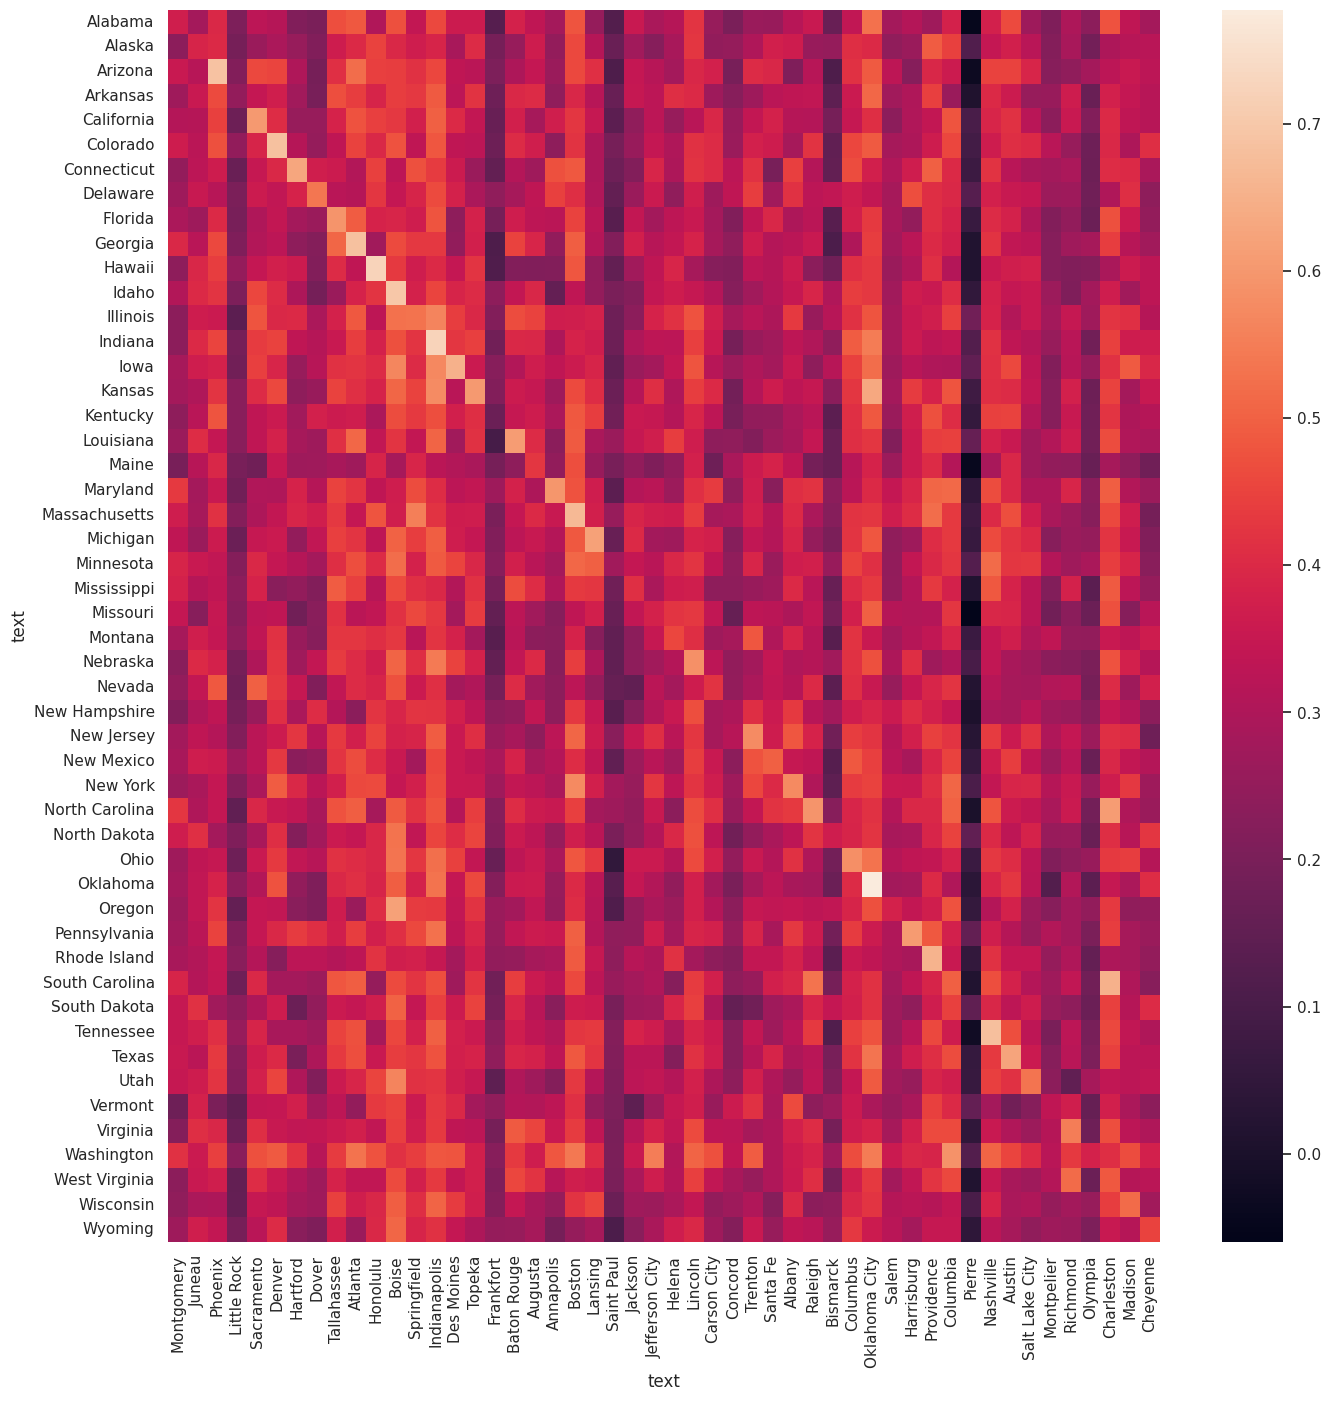

In [36]:
sns.heatmap(similarity_matrix)

In [35]:
# Find the most similar capital for each state based on the highest similarity score
most_similar_capitals = similarity_matrix.idxmax(axis=1)

# Display the most similar capitals for each state
most_similar_capitals

,0
text,
Alabama,Oklahoma City
Alaska,Providence
Arizona,Phoenix
Arkansas,Oklahoma City
California,Sacramento
Colorado,Denver
Connecticut,Hartford
Delaware,Dover
Florida,Tallahassee
